In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
random.seed(123)

# directory that contains pickle files
data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose')

# Helper functions

In [4]:
def data_generator(T, C, le):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    X = T['pose'] # list of arrays
    Y = np.zeros(shape=(len(T['label']), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(T['label'])] = 1
    return X, Y

In [5]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Load and Preprocess Data

In [6]:
Train = pickle.load(open(os.path.join(data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

LabelEncoder()

In [7]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=25, joint_dim=2, num_classes=21, num_filters=32)

X, Y = data_generator(Train,C,le)
X_test,Y_test = data_generator(Test,C,le)

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

272 (27, 25, 2) (272, 21)
98 (29, 25, 2) (98, 21)


### Convert Invisible Joints with `nan`

In [8]:
def make_nan(p, copy=True):
    """
    Convert 0 values to np.nan
    """
    assert isinstance(p, np.ndarray)
    q = p.copy() if copy else p
    q[q == 0] = np.nan
    return q

def has_nan(p):
    assert isinstance(p, np.ndarray)
    return np.isnan(p).any()

def count_nan(p):
    assert isinstance(p, np.ndarray)
    return np.isnan(p).sum()

X_nan = list(map(make_nan, X))
X_test_nan = list(map(make_nan, X_test))

print("Video without any nan: {} out of {}".format(len([p for p in X_nan if not has_nan(p)]), len(X_nan)))
print("nan entries in X_nan: {} out of {}".format(sum(map(count_nan, X_nan)), sum([p.size for p in X_nan])))

Video without any nan: 3 out of 272
nan entries in X_nan: 127278 out of 466500


### Preprocessing
* Select a subset of frequently-detected joints
* Temporal interpolate
* Fill the others with mean

In [9]:
def find_top_joints(X_nan, top=15):
    """
    Find the indices of the `top` most frequently-detected joints """
    count_nan_per_joint = np.array([sum([count_nan(p[:, j, :]) for p in X_nan]) for j in range(X_nan[0].shape[1])])
    print(count_nan_per_joint)
#     print(np.sort(count_nan_per_joint))
    good_joint_idx = np.argsort(count_nan_per_joint)[:top]
    return good_joint_idx

good_joint_idx = find_top_joints(X_nan)
print("Good joint indices:", sorted(good_joint_idx.tolist()))

# previous result:
# GOOD_JOINT_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 17] # top 12
# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18]  # top 15

def filter_joints(p, good_joint_idx):
    """
    Filter a point by only keeping joints in good_joint_idx
    """
    return p[:, good_joint_idx, :]

X_topj = [filter_joints(p, good_joint_idx) for p in X_nan]
X_test_topj = [filter_joints(p, good_joint_idx) for p in X_test_nan]

print("Video with nan before/after selecting top joints: {} / {}".format(
    sum(map(has_nan, X_nan)),
    sum(map(has_nan, X_topj))
))

print("nan entries in before/after selecting top joints: {} / {}".format(
    sum(map(count_nan, X_nan)),
    sum(map(count_nan, X_topj))
))

[ 4256     8    22  1054  2500    14  1118  3624  1404  1580  6584  9064
  1594  6882  9100  5104  6000  3010  4628 10008 10680  9548  9810 10220
  9466]
Good joint indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18]
Video with nan before/after selecting top joints: 269 / 250
nan entries in before/after selecting top joints: 127278 / 35916


In [10]:
def nan_helper(y):
    """Helper function to handle real indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def temporal_interp(p):
    """
    If a joint is detected in at least one frame in a video, 
    we interpolate the nan coordinates from other frames.
    This is done independently for each joint.
    Note: it can still leave some all-nan columns if a joint is never detected in any frame.
    """
    p = p.copy()
    for j in range(p.shape[1]): # joint
        for coord in range(p.shape[2]): # x, y (,z)
            view = p[:, j, coord]
            if np.isnan(view).all() or  not np.isnan(view).any():
                continue
            nans, idx = nan_helper(view)
            view[nans]= np.interp(idx(nans), idx(~nans), view[~nans])
    return p

X_interp = list(map(temporal_interp, X_topj))
X_test_interp = list(map(temporal_interp, X_test_topj))


print("Video with nan before/after temporal interp: {} / {}".format(
    sum(map(has_nan, X_topj)),
    sum(map(has_nan, X_interp))
))

print("nan entries in before/after temporal interp: {} / {}".format(
    sum(map(count_nan, X_topj)),
    sum(map(count_nan, X_interp))
))

Video with nan before/after temporal interp: 250 / 127
nan entries in before/after temporal interp: 35916 / 15588


In [11]:
def per_frame_fill_mean(p, copy=True):
    """
    For each frame independently:
        for x, y[, z] independently:
            Fill nan entries with the mean of all other joints' coordinates
    This is defnitely not perfect, but may help.
    """
    q = p.copy() if copy else p
    for f in range(q.shape[0]):
        for coord in range(q.shape[2]): # x,y
            view = q[f, :, coord]
            view[np.isnan(view)] = np.nanmean(view)
    
    return q
    
X_fillmean = [per_frame_fill_mean(p) for p in X_interp]
X_test_fillmean = [per_frame_fill_mean(p) for p in X_test_interp]
    
assert sum(map(count_nan, X_fillmean)) == 0, sum(map(count_nan, X_fillmean))
assert sum(map(count_nan, X_test_fillmean)) == 0, sum(map(count_nan, X_test_fillmean))

In [12]:
X_input = X_fillmean
X_test_input = X_test_fillmean

### DDNet's preprocess and config

In [13]:
# redefine config with new # of joints
C = ddnet.DDNetConfig(frame_length=32, num_joints=len(good_joint_idx), joint_dim=2, num_classes=21, num_filters=32)

X_0, X_1 = ddnet.preprocess_batch(X_input, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)

# Building the model

In [18]:
DD_Net = ddnet.create_DDNet(C)
DD_Net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4, 256)       436544      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 256)          0           model_3[1][0]              

# Train, Test and Save/Load the Model

### Train and plot loss/accuracy

In [ ]:
import keras
from keras.optimizers import *

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=200,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


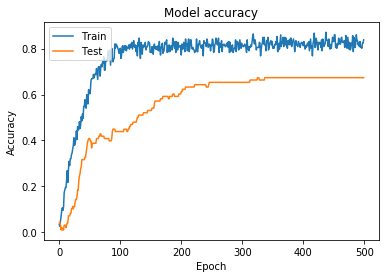

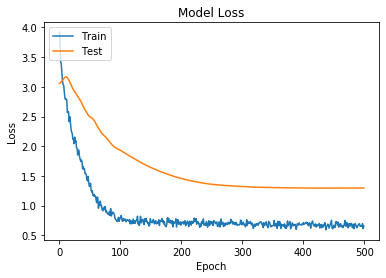

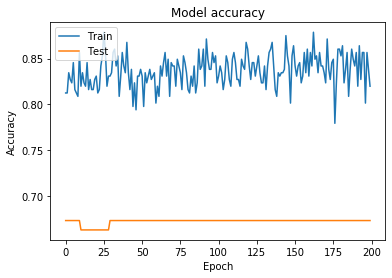

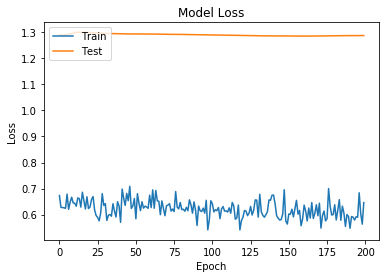

In [20]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [ ]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

In [ ]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
# print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

### Save/Load Model

In [ ]:
model_path = 'jhmdb_lite_model.h5'
ddnet.save_DDNet(DD_Net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
##########################
## Imputation
##########################

from sklearn.preprocessing import MinMaxScaler
def per_frame_normalized(p):
    # mean and std is calculated within a frame, across all joints
    # separately for x,y
    mean = np.nanmean(p, axis=(1,))
    std = np.nanstd(p, axis=(1,))
    return (p - np.expand_dims(mean, 1)) / np.expand_dims(std, 1)

def per_video_normalize(p):
    # noramlize x and y separate
    mean = np.nanmean(p, axis=(0,1))
    std = np.nanstd(p, axis=(0,1))
    return (p - mean) / std
    
# all_frames_normalized = np.concatenate(list(map(per_frame_normalized, X_interp)))
# print(all_frames_normalized.shape)
# print(all_frames_normalized[0])
# print(count_nan(all_frames_normalized))

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
imp = IterativeImputer(max_iter=10, random_state=0, initial_strategy='mean', verbose=1)
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
all_frames_normalized_flat_imputed = imp.fit_transform(all_frames_normalized.reshape((all_frames_normalized.shape[0], -1)))
print(all_frames_normalized_flat_imputed[0])

def impute(p, imp):
    # per-frame normalize
    mean = np.nanmean(p, axis=(1,))
    std = np.nanstd(p, axis=(1,))
    p_normalized = (p - np.expand_dims(mean, 1)) / np.expand_dims(std, 1)
    
    # impute
    q = p_normalized.reshape((p_normalized.shape[0], -1))
    q = imp.transform(q)
    q = q.reshape(p.shape)
    print(q.shape)
    # per-frame de-normalize
    return (q *  np.expand_dims(std, 1) ) + np.expand_dims(mean, 1)


# def per_frame_impute(p, imp):
#     q = np.empty_like(p)
#     for i, frame in enumerate(p):
#         scaler = MinMaxScaler()
#         frame_scaled = scaler.fit_transform(frame)
#         f_flat = frame_scaled.reshape((1, -1))
#         f_flat_imputed = imp.transform(f_flat)
#         f_imputed = f_flat_imputed.reshape(frame.shape)
#         frame_imputed = scaler.inverse_transform(f_imputed)
#         q[i] =  frame_imputed
#     return q
print(impute(X_interp[0], imp)[0])

X_imputed = [per_video_normalize(impute(p, imp)) for p in X_interp]
X_test_imputed = [per_video_normalize(impute(p, imp)) for p in X_test_interp]